In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.config import TailPreprocessingConfig,TrajPreprocessingConfig,TailSegmentationConfig
from megabouts.preprocessing import TailPreprocessingResult, TailPreprocessing,TrajPreprocessingResult, TrajPreprocessing
from megabouts.segmentation import TailSegmentation, Segmentation
from megabouts.classification import TailBouts,BoutClassifier
from megabouts.pipeline import EthogramFullTracking,FullTrackingPipeline
from megabouts.utils import bouts_category_color,bouts_category_name_short
from megabouts.utils import cmp_bouts


In [3]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

In [4]:
pipeline = FullTrackingPipeline(tracking_cfg,exclude_CS=True)

In [5]:
ethogram,bouts,segments,tail,traj = pipeline.run(tracking_data)

E:\Code\megabouts\megabouts\megabouts\classification\classification.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(transformer_weights_p

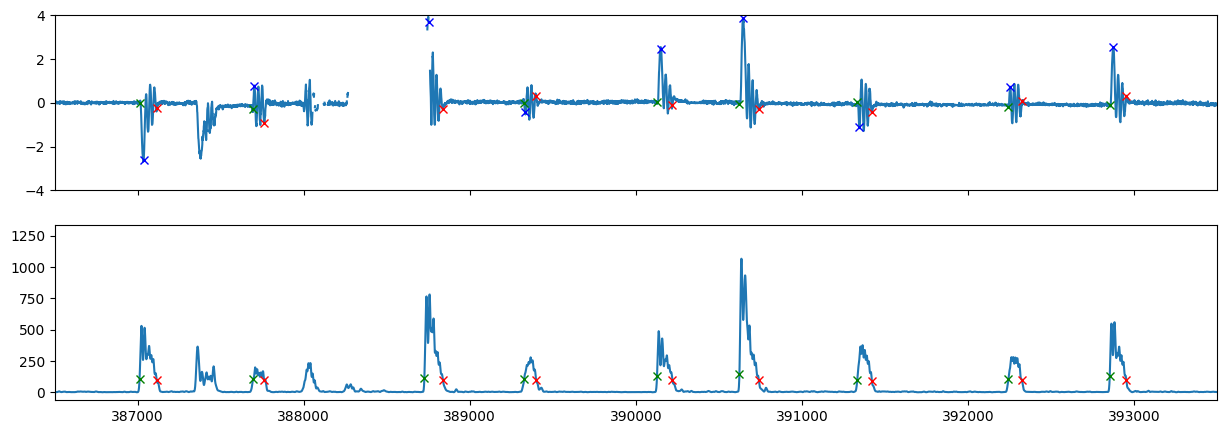

In [6]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x",color='green')
ax[0].plot(segments.offset, x[segments.offset], "x",color='red')
ax[0].plot(segments.HB1, x[segments.HB1], "x",color='blue')
ax[0].set_ylim(-4,4)

x = tail.vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x",color='green')
ax[1].plot(segments.offset, x[segments.offset], "x",color='red')

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = 386502#np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [21]:
from scipy import ndimage

from pybaselines.smooth import noise_median

(299182.0, 306182.0)

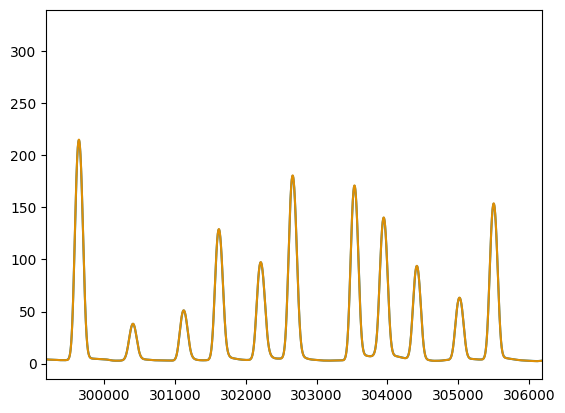

In [33]:
#plt.plot(x)
hw = 100
x[np.isnan(x)]=0


window_size = 2 * hw + 1
result = ndimage.median_filter(x, size=window_size,mode='constant',
                        cval=0)
result = ndimage.gaussian_filter(result, sigma=window_size/6)


baseline = noise_median(x,
                        half_window=hw, 
                        smooth_half_window=None,
                        sigma=None,
                        mode='constant',
                        constant_values=0)[0]
plt.plot(result)
plt.plot(baseline)
plt.xlim(IdSt,IdSt+700*10)

In [16]:
x.shape,result.shape

((420000,), (420000,))

In [7]:
import matplotlib.gridspec as gridspec

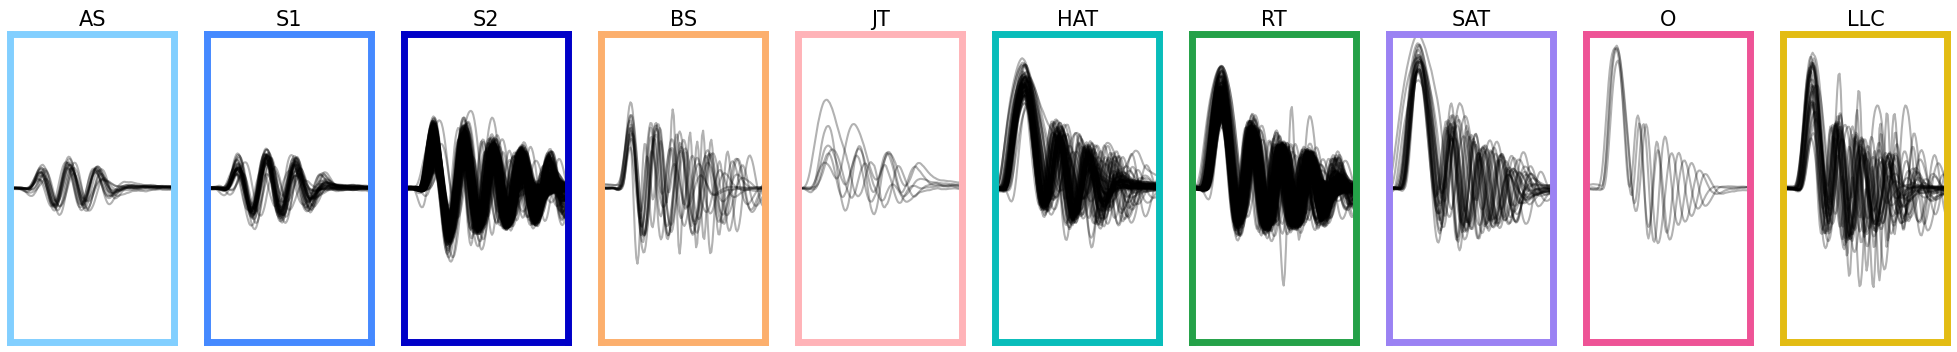

In [8]:
id_b = np.unique(bouts.df.label.category[bouts.df.label.proba>0.5]).astype('int')

fig, ax = plt.subplots(facecolor='white',figsize=(25,4)) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1,len(id_b))
ax0 = {}
for i,b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b],fontsize=15) 
    for i_sg,sg in enumerate([1,-1]):        
        #ax0.set_title(NameCat[b%11])
        id = bouts.df[(bouts.df.label.category==b) & (bouts.df.label.sign==sg)&(bouts.df.label.proba>0.5) ].index
        if len(id)>0:
            ax0.plot(sg*bouts.tail[id,7,:].T,color='k',alpha=.3)
        ax0.set_xlim(0,pipeline.segmentation_cfg.bout_duration)
        ax0.set_ylim(-4,4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ['top','bottom','left','right']:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)
    
plt.show()

In [9]:
from megabouts.utils import bouts_category_name_short,bouts_category_color
from megabouts.utils import colorblind_list,lighten_color
import matplotlib as mpl
from cycler import cycler
mpl.rc('axes',**{'prop_cycle':cycler('color',colorblind_list)})

num_colors = 8
cb_shades = [lighten_color(colorblind_list[2],x_) for x_ in np.linspace(.2, .9, num_colors)]
cb_cycler = cycler(color=cb_shades)
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(.2, .9, num_colors)))

C:\Users\adrien\AppData\Local\Temp\ipykernel_54388\805891363.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.imshow(ethogram.df[('bout','cat')].values[IdSt:IdEd].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=(0,T,0,1))
c:\Users\adrien\anaconda3\envs\megabouts_dev\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


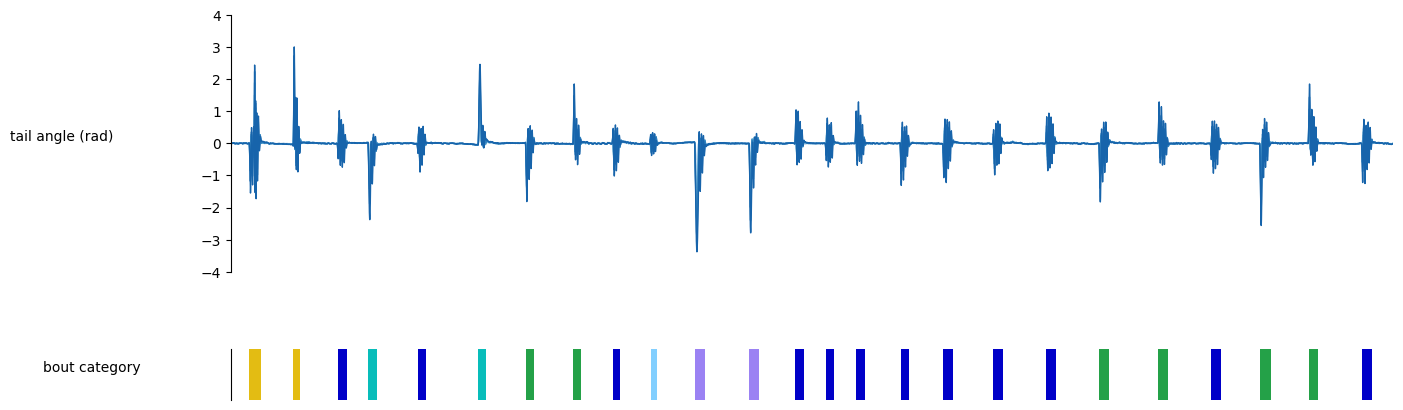

In [34]:
IdSt = 386502#
IdSt = np.random.randint(tracking_data.T)
T = 20
Duration = T*tracking_cfg.fps
IdEd = IdSt+Duration
t = np.arange(Duration)/tracking_cfg.fps


fig = plt.figure(facecolor='white', figsize=(15, 5), constrained_layout=True) 
G = gridspec.GridSpec(2,1,height_ratios=[1,0.2],hspace=.5)
ax = plt.subplot(G[0,0])
ax.set_prop_cycle(blue_cycler)

ax.plot(t,ethogram.df['tail_angle'].values[IdSt:IdEd,:7],lw=1)
ax.set_ylim(-4,4)
ax.set_xlim(0,T)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.set_ylabel('tail angle (rad)',rotation=0,labelpad=100)

ax = plt.subplot(G[1,0])
ax.imshow(ethogram.df[('bout','cat')].values[IdSt:IdEd].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=(0,T,0,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim(0,T)

ax.set_ylabel('bout category',rotation=0,labelpad=100)

plt.show()